1. input svg
2. deconstruct svg into layers
3. prepare each layer (masking), some layers have interaction
4. parse through terrain algorithm to get heightmap

In [18]:
import sys

sys.path.append('../terrain-erosion-3-ways/')
from river_network import *

sys.path.append("../pipeline")
from svg_extraction import SVGExtractor
from svg_extraction import get_city_coordinates, get_island_coordinates
from image_ops import flood_image

import numpy as np

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
import png
import PIL

In [19]:
# 13337
# 4425
# 4726
# 6316
# 7065
# 7576
realm_number = 4425

In [20]:
config = OmegaConf.load("../pipeline/config.yaml")
# this is how you can access the config
# we will use padding more often
config

{'svg': {'scaling': 2.0, 'padding': 50}, 'closing': {'min_n_points': 3, 'rng': 448, 'magnet': 10}, 'pipeline': {'use_rivers': True, 'use_cities': True, 'use_islands': True}, 'terrain': {'land': {'disc_radius': 1.0, 'max_delta': 0.05, 'river_downcutting_constant': 1.3, 'directional_inertia': 0.4, 'default_water_level': 1.0, 'evaporation_rate': 0.2, 'coastal_dropoff': 80.0, 'mountain_sigma': 5.0, 'lakes_alpha': 0.8, 'mountain_lower': 2.0, 'mountain_shape_offset': 0.4, 'mountain_offset': 0.1}, 'water_padding': 20, 'water': {'disc_radius': 1.0, 'max_delta': 0.05, 'river_downcutting_constant': 1.3, 'directional_inertia': 0.4, 'default_water_level': 1.0, 'evaporation_rate': 0.2, 'coastal_dropoff': 80.0, 'mountain_sigma': 5.0, 'lakes_alpha': 0.8, 'mountain_lower': 2.0, 'mountain_shape_offset': 0.4, 'mountain_offset': 0.1}}, 'export': {'size': 512}}

In [21]:
extractor = SVGExtractor(f"../svgs/{realm_number}.svg", scale=config.svg.scaling)

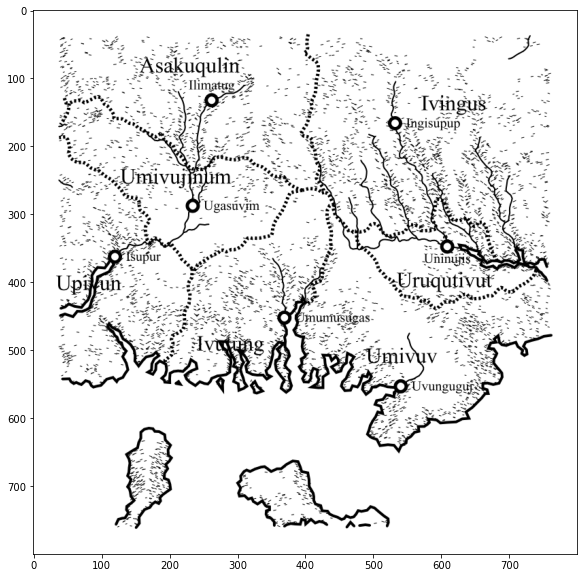

In [22]:
extractor.show()

In [23]:
drawing = extractor.height()

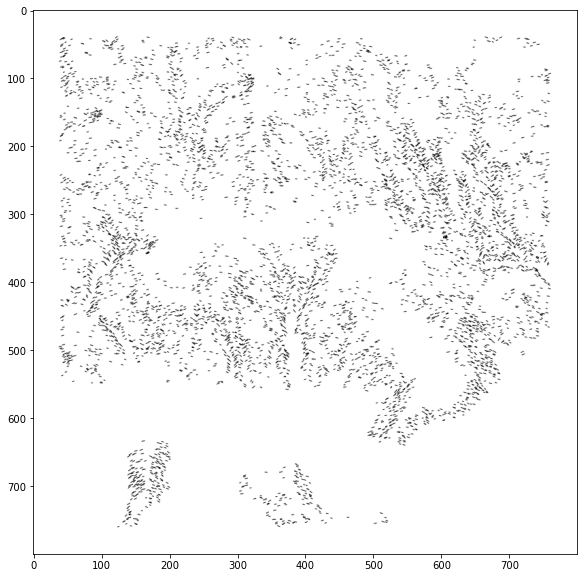

In [42]:
extractor.show()

In [70]:
def extract_gradients(drawing):
    """Extracts the gradients from lines in the drawing.
    This can be used to sample from when generating height.
    Returns list of coordinates with it's gradient w.r.t. the x-axis
    """
    
    EPS = 0.0001
    gradients = []
    
    for line in drawing.contents[0].contents:
        # let's calculate the gradient at the center
        center_x = (line.x2+line.x1)*.5
        center_y = (line.y2+line.y2)*.5
        denom = line.x2-line.x1
        
        if denom > EPS: # make sure we don't calc/add explosive gradients
            gradient = (line.y2-line.y1)/denom
            if abs(gradient)<3:
                gradients.append(np.array([center_x, center_y, gradient]))
    return np.vstack(gradients)
    
xygr = extract_gradients(drawing)


#normalize
xygr[:,0:1] = xygr[:,0:1] - xygr[:,0].min()
xygr[:,1:2] = xygr[:,1:2] - xygr[:,1].min()


In [71]:
x_max = xygr[:,0].max()
y_max = xygr[:,1].max()

ROW_RANGE = 3 # how much to look at the rows above and below
LOOKBACK_X = 5 # how much to look back

grmap = np.zeros((int(y_max)+2, int(x_max)+2))

for co in xygr:
    co /= 4
    floors = np.floor(co[:2])
    ceils = np.ceil(co[:2])
    alpha_x = co[0]-floors[0]
    alpha_y = co[1]-floors[1]
    beta_x = 1-alpha_x
    beta_y = 1-alpha_y
    grmap[int(floors[1]),int(floors[0])] += ( beta_y +  beta_x) * co[2]
    grmap[int(floors[1]), int(ceils[0])] += ( beta_y + alpha_x) * co[2]
    grmap[ int(ceils[1]),int(floors[0])] += (alpha_y +  beta_x) * co[2]
    grmap[ int(ceils[1]), int(ceils[0])] += (alpha_y + alpha_x) * co[2]
grmap = grmap[:int(y_max/4.)+2, :int(x_max/4.)+2]


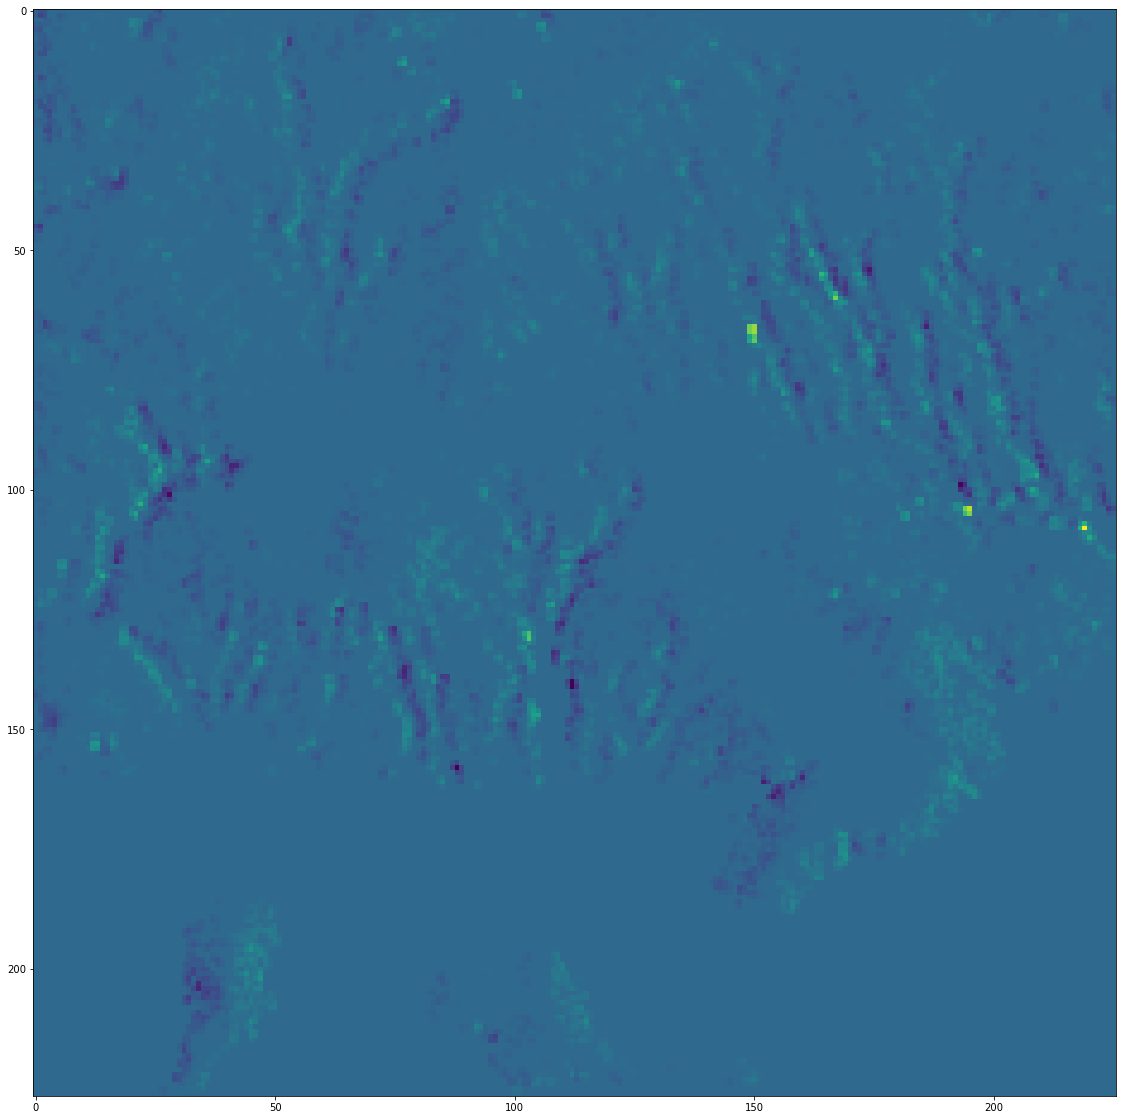

In [72]:
plt.figure(figsize=(20,20))
plt.imshow(grmap)

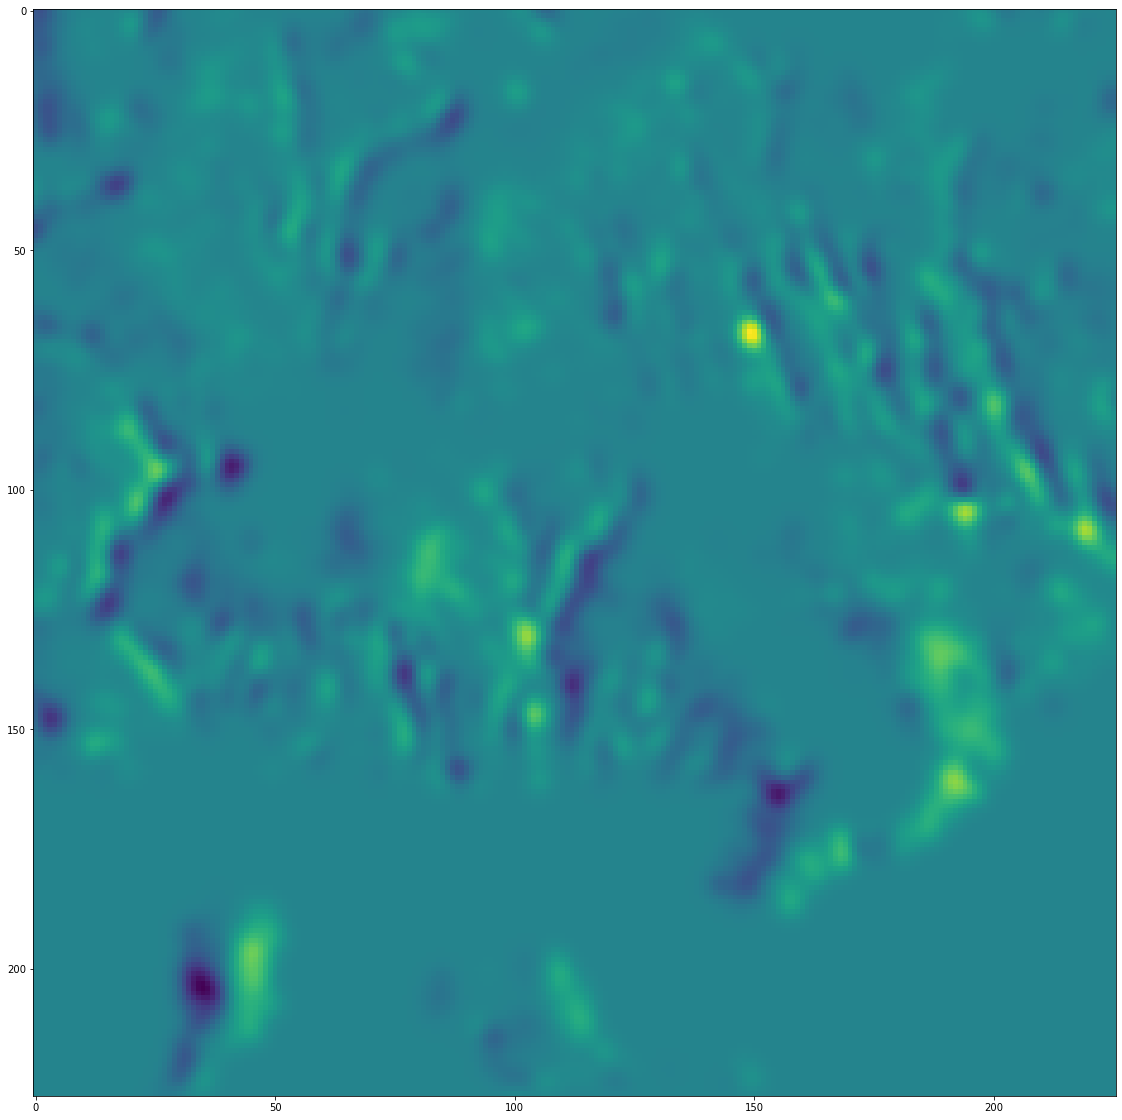

In [73]:
plt.figure(figsize=(20,20))
grmap = skimage.filters.gaussian(grmap, sigma=2)
plt.imshow(grmap)

(800, 800)


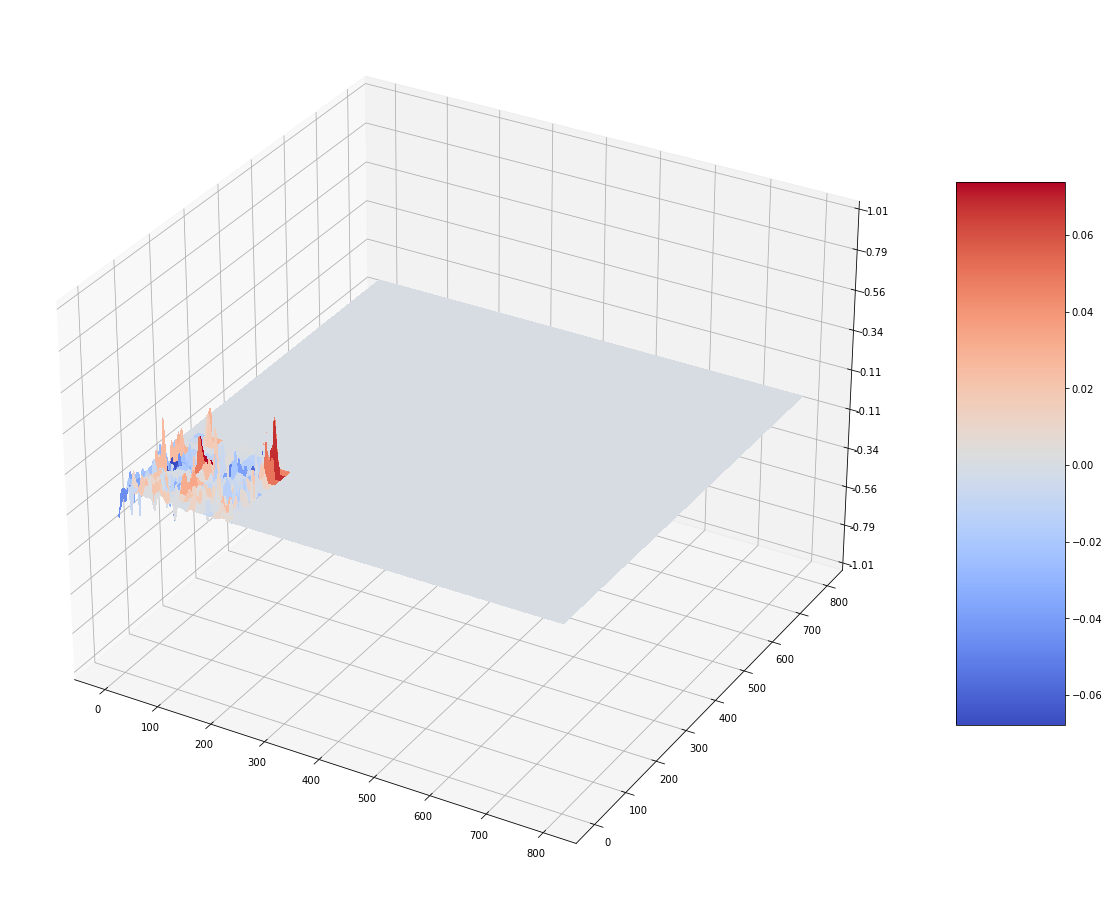

In [76]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(figsize=(20,20), subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 800, 1)
Y = np.arange(0, 800, 1)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((800,800))
for x in range(200):
    for y in range(200):
        Z[x,y] = grmap[x,y]
        
print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

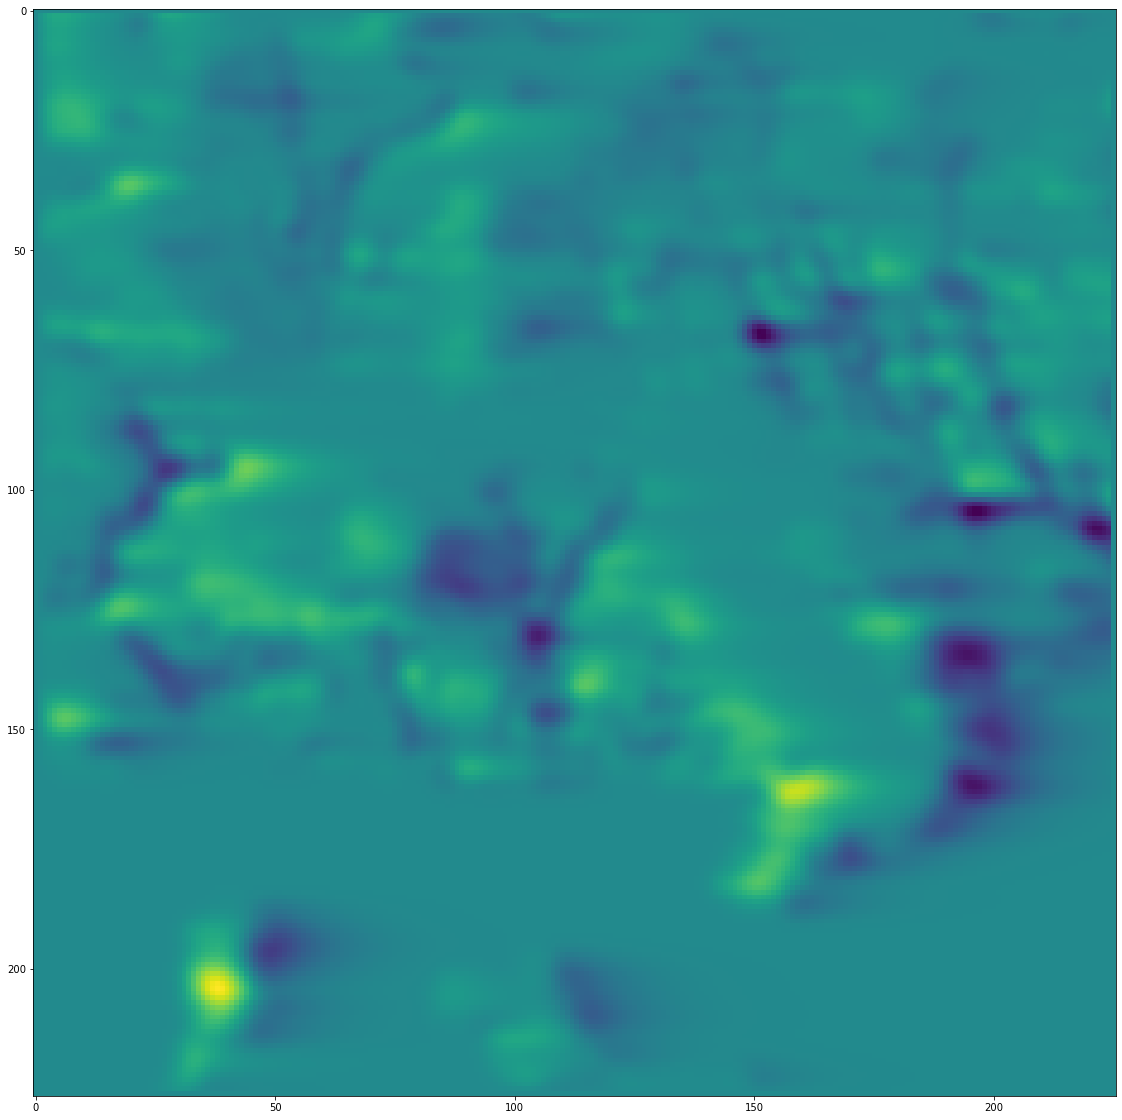

In [95]:
heightmap = np.zeros_like(grmap)

for row in range(1,heightmap.shape[0]-1):
    for col in range(1,heightmap.shape[1]-1):
        heightmap[row,col] = 0.9*heightmap[row, col-1] - grmap[row,col] # + 0.2*grmap[row-1,col] + 0.2*grmap[row+1,col]

plt.figure(figsize=(20,20))
plt.imshow(heightmap)

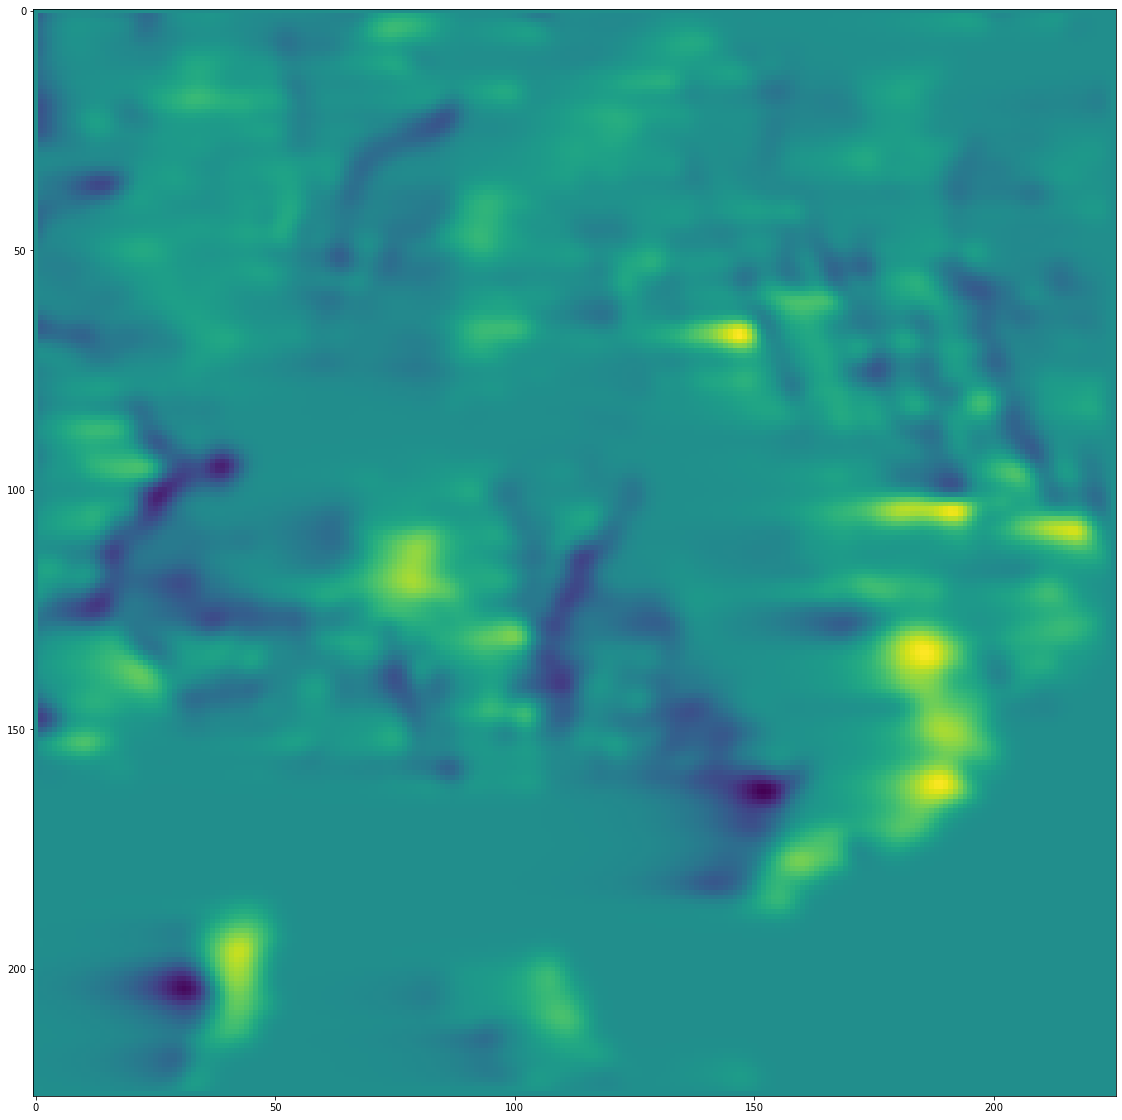

In [96]:
heightmap2 = np.zeros_like(grmap)

for row in range(1,heightmap.shape[0]-1):
    for col in range(1,heightmap.shape[1]-1)[::-1]:
        heightmap2[row,col] = 0.9*heightmap2[row,col+1] + grmap[row,col] # + 0.2*grmap[row-1,col] + 0.2*grmap[row+1,col]

plt.figure(figsize=(20,20))
plt.imshow(heightmap2)

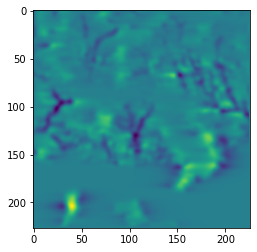

In [97]:
plt.imshow(heightmap+heightmap2)

In [88]:
exp = (heightmap-heightmap.min())/(heightmap.max()-heightmap.min())

In [89]:
exp.min()

0.0

In [90]:
exp.max()

1.0

In [91]:
exp

array([[0.55894094, 0.55894094, 0.55894094, ..., 0.55894094, 0.55894094,
        0.55894094],
       [0.55894094, 0.5850544 , 0.60863372, ..., 0.53324988, 0.53357351,
        0.55894094],
       [0.55894094, 0.58321232, 0.60497418, ..., 0.50275727, 0.50342184,
        0.55894094],
       ...,
       [0.55894094, 0.55894094, 0.55894094, ..., 0.55172714, 0.55179927,
        0.55894094],
       [0.55894094, 0.55894094, 0.55894094, ..., 0.55044636, 0.55053131,
        0.55894094],
       [0.55894094, 0.55894094, 0.55894094, ..., 0.55894094, 0.55894094,
        0.55894094]])

In [92]:
colorqmap_export = (exp*255).astype(np.uint8)
colorqmap_export = PIL.Image.fromarray(colorqmap_export)
colorqmap_export = colorqmap_export.resize((config.export.size, config.export.size))
colorqmap_export.save(f"../output/svgheight_{realm_number}.png")